# WBD CXCU Familiarity & Viewing Data

Streamlined analysis notebook (refactored):

1. Load raw data
2. Standardize / rename all Q3 & Q4 columns (including Sherlock Holmes fix)
3. Apply Likert mappings → numeric `df_scores`
4. Provide concise summary ready for analysis

All previous exploratory / debug cells retained further below (can be deleted after validation).

In [2]:
# --- 1. Load Data (Auto-detect survey file) ---
from pathlib import Path
import pandas as pd

DATA_DIR = Path('../data') if Path.cwd().name == 'analysis' else Path('data')

# Explicit preference order: survey grid file first if present
PREFERRED_NAMES = [
    'UOM251056541 - Grid-2.csv',
    'UOM251056541 - Grid-2.xlsx'
]

survey_path = None
for name in PREFERRED_NAMES:
    candidate = DATA_DIR / name
    if candidate.exists():
        survey_path = candidate
        print(f"Selected preferred survey file: {candidate.name}")
        break

# Fallback to heuristic if preferred not found
if survey_path is None:
    candidates = []
    for ext in ('*.csv', '*.xlsx'):
        candidates.extend(sorted(DATA_DIR.glob(ext)))
    if not candidates:
        raise FileNotFoundError(f"No data files found in {DATA_DIR}")
    for fp in candidates:
        try:
            if fp.suffix.lower() == '.csv':
                hdr_df = pd.read_csv(fp, nrows=1)
            else:
                hdr_df = pd.read_excel(fp, nrows=1)
            if any(str(col).startswith(('Q3.', 'Q4.')) for col in hdr_df.columns):
                survey_path = fp
                print(f"Heuristically detected survey file: {fp.name}")
                break
        except Exception:
            continue
    if survey_path is None:
        survey_path = candidates[0]
        print(f"[WARN] No Q3./Q4. headers found; falling back to {survey_path.name}")

# Load with encoding fallback for CSV; simple read for Excel
if survey_path.suffix.lower() == '.csv':
    encodings = ['utf-8', 'cp1252', 'latin-1']
    last_err = None
    for enc in encodings:
        try:
            df = pd.read_csv(survey_path, encoding=enc)
            print(f"Loaded CSV '{survey_path.name}' with encoding {enc}; shape={df.shape}")
            break
        except Exception as e:
            last_err = e
    if 'df' not in locals():
        raise last_err
else:
    df = pd.read_excel(survey_path)
    print(f"Loaded Excel '{survey_path.name}'; shape={df.shape}")

# Early Sherlock Holmes fix
if 'Q3.8.1. Sherlock Holmes' in df.columns and 'Q3.8.1. Sherlock Holmes Familiarity' not in df.columns:
    df.rename(columns={'Q3.8.1. Sherlock Holmes': 'Q3.8.1. Sherlock Holmes Familiarity'}, inplace=True)
    print("Applied Sherlock Holmes familiarity column fix.")

raw_q_columns = [c for c in df.columns if c.startswith(('Q3.', 'Q4.'))]
print(f"Found {len(raw_q_columns)} raw Q3/Q4 columns.")

Selected preferred survey file: UOM251056541 - Grid-2.csv
Loaded CSV 'UOM251056541 - Grid-2.csv' with encoding cp1252; shape=(106, 71)
Applied Sherlock Holmes familiarity column fix.
Found 50 raw Q3/Q4 columns.


In [3]:
# --- 2. Standardize / Rename Columns (Full legacy logic integrated) ---
import re, unicodedata

TITLE_CORRECTIONS = {
    'Dark Knight': 'The Dark Knight',
    'dark knight': 'The Dark Knight',
    'THE DARK KNIGHT': 'The Dark Knight',
    # Mis-encoded Schitt's Creek variants
    'Schitt�s Creek': "Schitt's Creek",
    'SchittÕs Creek': "Schitt's Creek",
    'Schitts Creek': "Schitt's Creek"
}

SUFFIX_NORMALIZATION = {
    'familiarity': 'Familiarity',
    'last watched': 'Lastwatched',
    'lastwatched': 'Lastwatched',
    'episodes': 'Episodes',
    'how many episodes': 'Episodes',
    'how many episodes?': 'Episodes'
}

# Extended text normalization
def normalize_text(s):
    if not isinstance(s, str):
        return s
    s = unicodedata.normalize('NFKC', s)
    replacements = {
        '\u2019': "'", '\u2018': "'", '\x92': "'", '\x91': "'", '�': "'",
        'Ive': "I've", 'dont': "don't", 'Dont': "Don't", 'I’': "I'",
    }
    for k,v in replacements.items():
        s = s.replace(k,v)
    # Collapse whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    return s

# Pattern: Q3./Q4. segments
pattern = re.compile(r'^Q([34])\.(\d+)\.(\d+)\.\s*(.+)$')

metric_map_tail = {
    'familiarity': 'Familiarity',
    'last watched': 'Lastwatched',
    'how many episodes': 'Episodes',
    'episodes': 'Episodes'
}

# Infer suffix for missing tail based on position number (legacy logic)
position_suffix_fallback = {'1': 'Familiarity', '2': 'Lastwatched', '3': 'Episodes'}

def clean_q_col(col: str):
    m = pattern.match(col)
    if not m:
        return col
    q, a, b, tail = m.groups()
    tail_norm = normalize_text(tail)
    tail_lower = tail_norm.lower()

    # Determine metric by tail ending keywords
    metric = None
    for key, canonical in metric_map_tail.items():
        if tail_lower.endswith(key):
            metric = canonical
            base = tail_norm[: -len(key)].strip()
            break
    if metric is None:
        # Fallback to position-based inference
        metric = position_suffix_fallback.get(b, 'Familiarity')
        base = tail_norm

    base = base.strip(' -_')

    # Title correction pass (exact matches)
    corrected_title = TITLE_CORRECTIONS.get(base, base)

    # Ensure "The Dark Knight" consistency if any variant contains 'Dark Knight'
    if re.fullmatch(r'(?i)dark knight', corrected_title):
        corrected_title = 'The Dark Knight'

    # Return standardized format with underscores for numeric parts
    return f"Q{q}_{a}_{b}_{corrected_title}_{metric}"

q_cols = [c for c in df.columns if c.startswith(('Q3.', 'Q4.'))]
renamed = {c: clean_q_col(c) for c in q_cols}

# Start df_clean with optional passthrough columns (like Name if present)
pass_through_cols = []
for col in ['Name', 'Participant', 'RespondentID']:
    if col in df.columns:
        pass_through_cols.append(col)

if pass_through_cols:
    df_clean = df[pass_through_cols + q_cols].copy().rename(columns=renamed)
else:
    df_clean = df[q_cols].copy().rename(columns=renamed)

# Normalize cell text values for mapping (retain punctuation; we map variants explicitly)
for c in df_clean.columns:
    if df_clean[c].dtype == object and c not in pass_through_cols:
        df_clean[c] = df_clean[c].apply(normalize_text)

print(f"Renamed to standardized schema: {len([c for c in df_clean.columns if c.startswith('Q')])} Q columns (+ {len(pass_through_cols)} passthrough)")
print("Passthrough columns:" if pass_through_cols else "No passthrough columns detected.")
if pass_through_cols:
    print(pass_through_cols)
print("Sample Q columns:")
print([c for c in df_clean.columns if c.startswith('Q')][:8])

Renamed to standardized schema: 50 Q columns (+ 1 passthrough)
Passthrough columns:
['Name']
Sample Q columns:
['Q3_1_1_The Dark Knight_Familiarity', 'Q3_1_2_The Dark Knight_Lastwatched', 'Q3_2_1_Iron Man_Familiarity', 'Q3_2_2_Iron Man_Lastwatched', 'Q3_3_1_Wonder Woman_Familiarity', 'Q3_3_2_Wonder Woman_Lastwatched', 'Q3_4_1_Mad Max Fury Road_Familiarity', 'Q3_4_2_Mad Max Fury Road_Lastwatched']


In [3]:
# --- 3. Likert Mapping & Numeric Conversion (Robust + Multi‑pass) ---
import unicodedata, re, numpy as np, pandas as pd

F_SUFFIX = '_Familiarity'
L_SUFFIX = '_Lastwatched'
E_SUFFIX = '_Episodes'

f_cols = [c for c in df_clean.columns if c.endswith(F_SUFFIX)]
l_cols = [c for c in df_clean.columns if c.endswith(L_SUFFIX)]
e_cols = [c for c in df_clean.columns if c.endswith(E_SUFFIX)]

# 1. Explicit variant dictionaries (authoritative variants we have observed)
familiarity_explicit = {
    'Never heard of it (not familiar).': 0,
    'Never heard of it (not familiar)': 0,
    'Heard of it, but never watched it.': 1,
    'Heard of it, but never watched it': 1,
    'Heard of it only.': 1,
    'Heard of it only': 1,
    'Seen a clip or part of it.': 2,
    'Seen a clip or part of it': 2,
    "Seen a clip or part of it (i.e., I've watched part of an episode).": 2,
    "Seen a clip or part of it (i.e., I've watched part of an episode)": 2,
    "Seen a clip or part of it (i.e., I’ve watched part of an episode).": 2,
    "Seen a clip or part of it (i.e., I’ve watched part of an episode)": 2,
    'Seen a clip or trailer': 2,
    'Seen a clip': 2,
    'Seen clips': 2,
    'Watched it in full (just once).': 3,
    'Watched it in full (just once)': 3,
    'Watched one episode': 3,
    'Watched 1 episode': 3,
    'Very familiar (e.g., watched multiple times).': 4,
    'Very familiar (e.g., watched multiple times)': 4,
    'Watched multiple episodes': 4,
    'Watched more than one episode': 4,
    'Watched more than one episode.': 4,
}

lastwatched_explicit = {
    "I don't remember.": 0,
    "I don't remember": 0,
    'I dont remember.': 0,
    'I dont remember': 0,
    'More than 6 months ago.': 0,  # treat as 0 (old logic sometimes used 1; decision: 0 aligns with recency scale top=4)
    'More than 6 months ago': 0,
    'Longer than 6 months ago.': 0,
    'Longer than 6 months ago': 0,
    'More than 3 months ago.': 1,
    'More than 3 months ago': 1,
    'Within the past 3 months.': 2,
    'Within the past 3 months': 2,
    'Within the past month.': 3,
    'Within the past month': 3,
    'Within the past week.': 4,
    'Within the past week': 4,
}

episodes_explicit = {
    'Only a few episodes.': 1,
    'Only a few episodes': 1,
    'All episodes from a single season.': 2,
    'All episodes from a single season': 2,
    'Most episodes from most seasons.': 3,
    'Most episodes from most seasons': 3,
    'Every episode from every season that has aired.': 4,
    'Every episode from every season that has aired': 4,
}

# 2. Normalization key builder
def norm_key(s: str) -> str:
    if not isinstance(s, str):
        return s
    s2 = unicodedata.normalize('NFKC', s)
    s2 = s2.replace('\u2019', "'").replace('\u2018', "'").replace('\x92', "'")
    s2 = s2.lower().strip()
    # drop trailing punctuation like periods
    s2 = re.sub(r'[.]+$', '', s2)
    s2 = re.sub(r'\s+', ' ', s2)
    return s2

# 3. Normalized dictionaries for second pass
familiarity_normalized = {norm_key(k): v for k, v in familiarity_explicit.items()}
lastwatched_normalized  = {norm_key(k): v for k, v in lastwatched_explicit.items()}
episodes_normalized     = {norm_key(k): v for k, v in episodes_explicit.items()}

# 4. Heuristic classifier (final fallback)
def classify_familiarity(t: str):
    if not isinstance(t, str): return np.nan
    n = norm_key(t)
    if 'never heard' in n or 'not familiar' in n: return 0
    if 'heard of' in n and ('never watched' in n or 'only' in n): return 1
    if 'clip' in n or 'trailer' in n or 'part of' in n: return 2
    if ('full' in n and 'once' in n) or 'one episode' in n or '1 episode' in n: return 3
    if 'very familiar' in n or 'multiple' in n or 'more than one' in n: return 4
    return np.nan

def classify_lastwatched(t: str):
    if not isinstance(t, str): return np.nan
    n = norm_key(t)
    if "don't remember" in n or 'dont remember' in n: return 0
    if '6 months' in n and ('more' in n or 'longer' in n): return 0
    if 'more than 3 months' in n: return 1
    if 'within the past 3 months' in n: return 2
    if 'within the past month' in n: return 3
    if 'within the past week' in n: return 4
    return np.nan

def classify_episodes(t: str):
    if not isinstance(t, str): return np.nan
    n = norm_key(t)
    if 'only a few' in n: return 1
    if 'single season' in n: return 2
    if 'most episodes from most seasons' in n: return 3
    if 'every episode from every season' in n: return 4
    return np.nan

# 5. Multi-pass mapping

def multi_map(series: pd.Series, explicit: dict, normalized: dict, classifier) -> pd.Series:
    # Pass 1: direct explicit
    out = series.map(explicit)
    mask = out.isna() & series.notna()
    if mask.any():
        # Pass 2: normalized lookup
        normalized_keys = series[mask].apply(norm_key)
        out.loc[mask] = normalized_keys.map(normalized)
    mask = out.isna() & series.notna()
    if mask.any():
        # Pass 3: heuristic classification
        out.loc[mask] = series[mask].apply(classifier)
    return out

# Apply mapping passes
print("Applying multi-pass mapping...")

df_scores = df_clean.copy()

for c in f_cols:
    df_scores[c] = multi_map(df_clean[c], familiarity_explicit, familiarity_normalized, classify_familiarity)
for c in l_cols:
    df_scores[c] = multi_map(df_clean[c], lastwatched_explicit, lastwatched_normalized, classify_lastwatched)
for c in e_cols:
    df_scores[c] = multi_map(df_clean[c], episodes_explicit, episodes_normalized, classify_episodes)

# Metrics
fam_total = sum(df_scores[c].notna().sum() for c in f_cols)
last_total = sum(df_scores[c].notna().sum() for c in l_cols)
ep_total = sum(df_scores[c].notna().sum() for c in e_cols)

print("Conversion counts (non-null values):")
print(f"  Familiarity: {fam_total}")
print(f"  Last watched: {last_total}")
print(f"  Episodes: {ep_total}")
print(f"  Total: {fam_total + last_total + ep_total}")
print(f"Familiarity columns: {len(f_cols)} | Last watched: {len(l_cols)} | Episodes: {len(e_cols)}")

# Report any remaining unmapped unique values (should normally be none or very few)
remaining = {}
for label, cols, classifier in [
    ("Familiarity", f_cols, classify_familiarity),
    ("Lastwatched", l_cols, classify_lastwatched),
    ("Episodes", e_cols, classify_episodes)
]:
    raw_vals = set()
    unmapped = set()
    for col in cols:
        ser = df_clean[col].dropna()
        raw_vals.update(ser.unique())
        mask = df_scores[col].isna() & ser.notna()
        unmapped.update(ser[mask].unique())
    if unmapped:
        remaining[label] = sorted(unmapped)

if remaining:
    print("\n⚠️ Unmapped residual values detected:")
    for k,v in remaining.items():
        print(f"  {k}: {len(v)} → {v[:6]}{'...' if len(v)>6 else ''}")
else:
    print("\nAll observed response texts successfully mapped.")

Applying multi-pass mapping...
Conversion counts (non-null values):
  Familiarity: 1134
  Last watched: 710
  Episodes: 228
  Total: 2072
Familiarity columns: 21 | Last watched: 21 | Episodes: 8

All observed response texts successfully mapped.


In [4]:
# --- 3A. Ensure passthrough ID columns retained in df_scores before mapping ---
_passthrough_cols = [c for c in df_clean.columns if not c.startswith('Q')]
# Initialize df_scores from df_clean so Name (etc.) carries over, then numeric mapping will overwrite only Q columns
# (Existing code below will overwrite df_scores assignment; we pre-seed to avoid losing Name)
# If existing code already defines df_scores later, this acts as a base.
try:
    if _passthrough_cols:
        df_scores = df_clean[_passthrough_cols].copy()
except Exception:
    pass

In [5]:
# --- 4. Summary (Shape & Basic Stats) ---

print("DataFrames:")
print(f"  Raw df shape:       {df.shape}")
print(f"  Clean (text) shape:  {df_clean.shape}")
print(f"  Scores shape:        {df_scores.shape}")

f_cols = [c for c in df_scores.columns if c.endswith('_Familiarity')]
l_cols = [c for c in df_scores.columns if c.endswith('_Lastwatched')]
e_cols = [c for c in df_scores.columns if c.endswith('_Episodes')]

print("\nColumn counts by type:")
print(f"  Familiarity: {len(f_cols)}  Last watched: {len(l_cols)}  Episodes: {len(e_cols)}")

print("\nNon-null response counts (post-mapping):")
print(f"  Familiarity: {sum(df_scores[c].notna().sum() for c in f_cols)}")
print(f"  Last watched: {sum(df_scores[c].notna().sum() for c in l_cols)}")
print(f"  Episodes: {sum(df_scores[c].notna().sum() for c in e_cols)}")

print("\nScales:")
print("  Familiarity: 0=Never heard, 1=Heard only, 2=Seen clip, 3=Watched 1 ep, 4=Watched >1 ep")
print("  Last watched: 4=Past week ... 0=6+ months / don't remember")
print("  Episodes: 1=1-3, 2=4-6, 3=7-10, 4=More than 10")

print("\nPreview (first 3 familiarity cols, head 5):")
print(df_scores[f_cols[:3]].head())

DataFrames:
  Raw df shape:       (106, 71)
  Clean (text) shape:  (106, 51)
  Scores shape:        (106, 1)

Column counts by type:
  Familiarity: 0  Last watched: 0  Episodes: 0

Non-null response counts (post-mapping):
  Familiarity: 0
  Last watched: 0
  Episodes: 0

Scales:
  Familiarity: 0=Never heard, 1=Heard only, 2=Seen clip, 3=Watched 1 ep, 4=Watched >1 ep
  Last watched: 4=Past week ... 0=6+ months / don't remember
  Episodes: 1=1-3, 2=4-6, 3=7-10, 4=More than 10

Preview (first 3 familiarity cols, head 5):
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


In [6]:
# --- 4B. Drop rows with NaN Name (if Name exists) ---
if 'Name' in df_scores.columns:
    before = len(df_scores)
    mask_valid = df_scores['Name'].notna() & (df_scores['Name'].astype(str).str.strip()!='')
    df_scores = df_scores.loc[mask_valid].reset_index(drop=True)
    if 'Name' in df_clean.columns:
        df_clean = df_clean.loc[mask_valid].reset_index(drop=True)
    print(f"Filtered rows on non-null Name: {before} -> {len(df_scores)} (dropped {before-len(df_scores)})")
else:
    print("No 'Name' column found; skipping row filter.")

Filtered rows on non-null Name: 106 -> 54 (dropped 52)


In [7]:
# --- 4A. Diagnostics: Why so many NaNs? ---
import re, math
import pandas as pd

print("🔎 DIAGNOSTIC: Mapping Coverage per Column")
print("="*72)

coverage_rows = []
unmapped_examples = {}

for col in df_scores.columns:
    raw_non_null = df_clean[col].notna().sum()
    scored_non_null = df_scores[col].notna().sum()
    if raw_non_null == 0:
        pct = math.nan
    else:
        pct = scored_non_null / raw_non_null
    # Collect up to 3 raw values that failed to map
    if raw_non_null and scored_non_null < raw_non_null:
        mask_unmapped = df_clean[col].notna() & df_scores[col].isna()
        vals = df_clean.loc[mask_unmapped, col].dropna().unique()
        if len(vals):
            unmapped_examples[col] = list(vals[:3])
    coverage_rows.append({
        'column': col,
        'raw_non_null': raw_non_null,
        'scored_non_null': scored_non_null,
        'pct_mapped': pct
    })

coverage_df = pd.DataFrame(coverage_rows)

overall_raw = coverage_df.raw_non_null.sum()
overall_scored = coverage_df.scored_non_null.sum()
overall_pct = overall_scored / overall_raw if overall_raw else float('nan')

print(f"Total raw text responses (non-null): {overall_raw}")
print(f"Total scored responses:            {overall_scored}")
print(f"Overall mapping success:          {overall_pct:.1%}")

print("\nColumns with < 100% mapping (showing lowest 15 by pct):")
low = coverage_df[coverage_df['raw_non_null']>0].copy()
low['pct_mapped'] = low['pct_mapped']*100
low = low.sort_values('pct_mapped').head(15)
print(low[['column','raw_non_null','scored_non_null','pct_mapped']].to_string(index=False, formatters={'pct_mapped': lambda v: f"{v:5.1f}%"}))

if unmapped_examples:
    print("\nSample unmapped raw response variants (first 3 each):")
    for c, vals in list(unmapped_examples.items())[:10]:  # cap output
        print(f"  {c}: {vals}")
else:
    print("\nNo unmapped variants detected — sparsity is due to genuinely blank responses / skip logic.")

# --- 4B. Heuristic check: Are NaNs structural (skip logic) or mapping gaps? ---
# We infer potential skip logic: Lastwatched/Episodes should only exist when familiarity >= 3 or >=4.

print("\n⛏ Structural Skip Logic Probe")

# Extract familiarity, lastwatched, episodes groupings by title root
pattern = re.compile(r'^(Q[34]_\d+)_\d+_(.+?)_(Familiarity|Lastwatched|Episodes)$')
triples = {}
for col in df_scores.columns:
    m = re.match(r'^(Q[34]_\d+_\d+)_(.+)_(Familiarity|Lastwatched|Episodes)$', col)
    if not m:
        continue
    stem, title, metric = m.groups()
    key = f"{stem}_{title}"
    triples.setdefault(key, {})[metric] = col

logic_rows = []
for key, mapping in triples.items():
    fam_col = mapping.get('Familiarity')
    lw_col = mapping.get('Lastwatched')
    ep_col = mapping.get('Episodes')
    fam_high = df_scores[fam_col] >= 3 if fam_col in df_scores else pd.Series([False]*len(df_scores))
    fam_vhigh = df_scores[fam_col] >= 4 if fam_col in df_scores else pd.Series([False]*len(df_scores))
    lw_non_null = df_scores[lw_col].notna().sum() if lw_col in df_scores else 0
    ep_non_null = df_scores[ep_col].notna().sum() if ep_col in df_scores else 0
    fam_non_null = df_scores[fam_col].notna().sum() if fam_col in df_scores else 0
    lw_expected = fam_high.sum() if lw_col else 0
    ep_expected = fam_vhigh.sum() if ep_col else 0
    logic_rows.append({
        'title_key': key,
        'fam_non_null': fam_non_null,
        'lw_non_null': lw_non_null,
        'lw_expected_if_fam>=3': lw_expected,
        'ep_non_null': ep_non_null,
        'ep_expected_if_fam>=4': ep_expected
    })
logic_df = pd.DataFrame(logic_rows)

if not logic_df.empty:
    mismatch_lw = (logic_df['lw_non_null'] < logic_df['lw_expected_if_fam>=3']).sum()
    mismatch_ep = (logic_df['ep_non_null'] < logic_df['ep_expected_if_fam>=4']).sum()
    print(f"Last watched columns with fewer responses than familiarity>=3 count: {mismatch_lw}")
    print(f"Episodes columns with fewer responses than familiarity>=4 count:    {mismatch_ep}")
    if mismatch_lw==0 and mismatch_ep==0:
        print("✓ Observed sparsity aligns with inferred skip logic (no unexpected deficits).")
else:
    print("No triple metric groups detected for skip logic evaluation.")

# --- 4C. Optional: Quick lenient remap preview (without altering df_scores) ---
import unicodedata

def norm_simple(s):
    if not isinstance(s, str):
        return s
    s2 = unicodedata.normalize('NFKC', s)
    s2 = s2.replace('\u2019', "'").replace('\u2018', "'").replace('\x92', "'")
    s2 = re.sub(r'[.]+$','', s2.strip())
    return s2.lower()

# Canonical normalized keys (period-insensitive)
canon_fam = {
    norm_simple('Never heard of it (not familiar).'): 0,
    norm_simple('Heard of it, but never watched it.'): 1,
    norm_simple('Seen a clip or part of it.'): 2,
    norm_simple("Seen a clip or part of it (i.e., I've watched part of an episode)."): 2,
    norm_simple('Watched it in full (just once).'): 3,
    norm_simple('Very familiar (e.g., watched multiple times).'): 4,
}
canon_lw = {
    norm_simple("I don't remember."): 0,
    norm_simple('More than 6 months ago.'): 0,  # treat as 0 per earlier decision
    norm_simple('More than 3 months ago.'): 1,
    norm_simple('Within the past 3 months.'): 2,
    norm_simple('Within the past month.'): 3,
    norm_simple('Within the past week.'): 4,
}
canon_ep = {
    norm_simple('Only a few episodes.'): 1,
    norm_simple('All episodes from a single season.'): 2,
    norm_simple('Most episodes from most seasons.'): 3,
    norm_simple('Every episode from every season that has aired.'): 4,
}

lenient_scores = {}
for col in df_clean.columns:
    series = df_clean[col]
    if 'familiarity' in col.lower():
        lenient_scores[col] = series.apply(lambda x: canon_fam.get(norm_simple(x), math.nan))
    elif 'lastwatched' in col.lower():
        lenient_scores[col] = series.apply(lambda x: canon_lw.get(norm_simple(x), math.nan))
    elif 'episodes' in col.lower():
        lenient_scores[col] = series.apply(lambda x: canon_ep.get(norm_simple(x), math.nan))

lenient_totals = sum(s.notna().sum() for s in lenient_scores.values())
print(f"\nLenient remap (period/quote insensitive) total scored responses: {lenient_totals} (vs current {overall_scored})")
if lenient_totals > overall_scored:
    print("→ You can adopt the lenient normalization approach above to recover additional mappings.")
else:
    print("→ Lenient normalization does not increase mapping coverage; sparsity is structural.")

🔎 DIAGNOSTIC: Mapping Coverage per Column
Total raw text responses (non-null): 54
Total scored responses:            54
Overall mapping success:          100.0%

Columns with < 100% mapping (showing lowest 15 by pct):
column  raw_non_null  scored_non_null pct_mapped
  Name            54               54     100.0%

No unmapped variants detected — sparsity is due to genuinely blank responses / skip logic.

⛏ Structural Skip Logic Probe
No triple metric groups detected for skip logic evaluation.

Lenient remap (period/quote insensitive) total scored responses: 2072 (vs current 54)
→ You can adopt the lenient normalization approach above to recover additional mappings.


In [8]:
# Check what text values we actually have and update mappings
print("🔍 CHECKING ACTUAL TEXT VALUES FOR PROPER MAPPING")
print("=" * 60)

# Get all unique text values from the clean data
familiarity_values = set()
lastwatched_values = set()
episodes_values = set()

for col in df_clean.columns:
    if col.startswith('Q'):
        unique_vals = df_clean[col].dropna().unique()
        
        if 'familiarity' in col.lower():
            familiarity_values.update(unique_vals)
        elif 'lastwatched' in col.lower():
            lastwatched_values.update(unique_vals)
        elif 'episodes' in col.lower():
            episodes_values.update(unique_vals)

print("🎯 FAMILIARITY VALUES FOUND:")
for i, val in enumerate(sorted(familiarity_values), 1):
    print(f"{i}. {repr(val)}")

print("\n🎯 LAST WATCHED VALUES FOUND:")
for i, val in enumerate(sorted(lastwatched_values), 1):
    print(f"{i}. {repr(val)}")

print("\n🎯 EPISODES VALUES FOUND:")
for i, val in enumerate(sorted(episodes_values), 1):
    print(f"{i}. {repr(val)}")

# Create comprehensive mappings with exact text
print(f"\n🔧 CREATING COMPREHENSIVE MAPPINGS...")

# Updated familiarity mapping with all found values
familiarity_mapping_complete = {
    'Never heard of it (not familiar).': 0,
    'Heard of it, but never watched it.': 1,
    'Seen a clip or part of it.': 2,
    'Watched it in full (just once).': 3,
    'Very familiar (e.g., watched multiple times).': 4,
    np.nan: np.nan
}

# Add any additional familiarity values we found
for val in familiarity_values:
    if val not in familiarity_mapping_complete:
        if 'never heard' in str(val).lower() or 'not familiar' in str(val).lower():
            familiarity_mapping_complete[val] = 0
        elif 'heard of' in str(val).lower() and 'never watched' in str(val).lower():
            familiarity_mapping_complete[val] = 1
        elif 'clip' in str(val).lower() or 'part of' in str(val).lower():
            familiarity_mapping_complete[val] = 2
        elif 'full' in str(val).lower() and 'once' in str(val).lower():
            familiarity_mapping_complete[val] = 3
        elif 'familiar' in str(val).lower() and ('multiple' in str(val).lower() or 'very' in str(val).lower()):
            familiarity_mapping_complete[val] = 4
        print(f"Added familiarity: {repr(val)} → score based on content analysis")

# Updated last watched mapping
lastwatched_mapping_complete = {
    'More than 3 months ago.': 1,
    'Within the past 3 months.': 2,
    'Within the past month.': 3,
    'Within the past week.': 4,
    np.nan: np.nan
}

# Add any additional last watched values
for val in lastwatched_values:
    if val not in lastwatched_mapping_complete:
        if 'remember' in str(val).lower() and "don't" in str(val).lower():
            lastwatched_mapping_complete[val] = 0
        elif '6 months' in str(val).lower():
            lastwatched_mapping_complete[val] = 1
        print(f"Added lastwatched: {repr(val)} → score based on content analysis")

# Updated episodes mapping
episodes_mapping_complete = {
    'Only a few episodes.': 1,
    'All episodes from a single season.': 2,
    'Most episodes from most seasons.': 3,
    'Every episode from every season that has aired.': 4,
    np.nan: np.nan
}

print(f"📊 MAPPING SUMMARY:")
print(f"   • Familiarity mappings: {len(familiarity_mapping_complete)}")
print(f"   • Last watched mappings: {len(lastwatched_mapping_complete)}")
print(f"   • Episodes mappings: {len(episodes_mapping_complete)}")

# Update global mappings
familiarity_mapping = familiarity_mapping_complete
lastwatched_mapping = lastwatched_mapping_complete  
episodes_mapping = episodes_mapping_complete

print(f"✅ Updated global mapping variables")

🔍 CHECKING ACTUAL TEXT VALUES FOR PROPER MAPPING
🎯 FAMILIARITY VALUES FOUND:
1. 'Heard of it, but never watched it.'
2. 'Never heard of it (not familiar).'
3. "Seen a clip or part of it (i.e., I've watched part of an episode)."
4. 'Seen a clip or part of it.'
5. 'Very familiar (e.g., watched multiple times).'
6. 'Watched it in full (just once).'

🎯 LAST WATCHED VALUES FOUND:
1. "I don't remember."
2. 'More than 3 months ago.'
3. 'More than 6 months ago.'
4. 'Within the past 3 months.'
5. 'Within the past month.'
6. 'Within the past week.'

🎯 EPISODES VALUES FOUND:
1. 'All episodes from a single season.'
2. 'Every episode from every season that has aired.'
3. 'Most episodes from most seasons.'
4. 'Only a few episodes.'

🔧 CREATING COMPREHENSIVE MAPPINGS...
Added familiarity: "Seen a clip or part of it (i.e., I've watched part of an episode)." → score based on content analysis
Added lastwatched: "I don't remember." → score based on content analysis
Added lastwatched: 'More than 6 months 

In [9]:
# Normalize special characters in text data
print("🔧 NORMALIZING SPECIAL CHARACTERS")
print("=" * 60)

def normalize_text(text):
    """Replace special characters with standard equivalents"""
    if pd.isna(text) or not isinstance(text, str):
        return text
    
    # Replace common special characters
    normalized = text
    
    # Replace curly apostrophes with straight apostrophes
    normalized = normalized.replace('\x92', "'")  # Right single quotation mark
    normalized = normalized.replace('\u2019', "'")  # Unicode right single quotation mark
    normalized = normalized.replace('\u2018', "'")  # Unicode left single quotation mark
    
    # Replace curly quotes with straight quotes
    normalized = normalized.replace('\u201c', '"')  # Left double quotation mark
    normalized = normalized.replace('\u201d', '"')  # Right double quotation mark
    
    # Replace em dashes with hyphens
    normalized = normalized.replace('\u2014', '-')  # Em dash
    normalized = normalized.replace('\u2013', '-')  # En dash
    
    return normalized

# Apply normalization to all text columns in df_clean
print("Normalizing text in df_clean...")

df_clean_normalized = df_clean.copy()
text_changes = []

for column in df_clean.columns:
    if column.startswith('Q'):
        # Get original values
        original_values = df_clean[column].dropna().unique()
        
        # Apply normalization
        df_clean_normalized[column] = df_clean[column].apply(normalize_text)
        
        # Track changes
        normalized_values = df_clean_normalized[column].dropna().unique()
        
        # Check if any values changed
        for orig_val in original_values:
            norm_val = normalize_text(orig_val)
            if orig_val != norm_val:
                text_changes.append((column, orig_val, norm_val))

print(f"✅ Normalization complete!")
print(f"Text changes made: {len(text_changes)}")

if text_changes:
    print(f"\nChanges applied:")
    for col, orig, norm in text_changes[:10]:  # Show first 10 changes
        print(f"   • {repr(orig)} → {repr(norm)}")
    
    if len(text_changes) > 10:
        print(f"   ... and {len(text_changes) - 10} more changes")

# Update our working dataset
df_clean = df_clean_normalized

print(f"\n🔍 CHECKING NORMALIZED VALUES:")
# Re-check the problematic values
for col in df_clean.columns:
    if col.startswith('Q'):
        unique_vals = df_clean[col].dropna().unique()
        for val in unique_vals:
            if "I don'" in str(val) or "I've" in str(val):
                print(f"   • {repr(val)} (normalized)")

print(f"✅ df_clean now contains normalized text without special characters")

🔧 NORMALIZING SPECIAL CHARACTERS
Normalizing text in df_clean...
✅ Normalization complete!
Text changes made: 0

🔍 CHECKING NORMALIZED VALUES:
   • "I don't remember." (normalized)
   • "I don't remember." (normalized)
   • "I don't remember." (normalized)
   • "I don't remember." (normalized)
   • "I don't remember." (normalized)
   • "I don't remember." (normalized)
   • "I don't remember." (normalized)
   • "I don't remember." (normalized)
   • "I don't remember." (normalized)
   • "I don't remember." (normalized)
   • "I don't remember." (normalized)
   • "Seen a clip or part of it (i.e., I've watched part of an episode)." (normalized)
   • "Seen a clip or part of it (i.e., I've watched part of an episode)." (normalized)
   • "I don't remember." (normalized)
   • "Seen a clip or part of it (i.e., I've watched part of an episode)." (normalized)
   • "I don't remember." (normalized)
   • "Seen a clip or part of it (i.e., I've watched part of an episode)." (normalized)
   • "I don't r

In [10]:
# Create clean Likert mappings with normalized text
print("🔧 CREATING CLEAN LIKERT MAPPINGS")
print("=" * 60)

# Define clean Likert mappings using normalized text (no special characters)
familiarity_mapping_clean = {
    'Never heard of it (not familiar).': 0,
    'Heard of it, but never watched it.': 1,
    'Seen a clip or part of it.': 2,
    "Seen a clip or part of it (i.e., I've watched part of an episode).": 2,  # Same as "Seen a clip"
    'Watched it in full (just once).': 3,
    'Very familiar (e.g., watched multiple times).': 4,
    np.nan: np.nan
}

lastwatched_mapping_clean = {
    "I don't remember.": 0,
    'More than 6 months ago.': 1,
    'More than 3 months ago.': 1,
    'Within the past 3 months.': 2,
    'Within the past month.': 3,
    'Within the past week.': 4,
    np.nan: np.nan
}

episodes_mapping_clean = {
    'Only a few episodes.': 1,
    'All episodes from a single season.': 2,
    'Most episodes from most seasons.': 3,
    'Every episode from every season that has aired.': 4,
    np.nan: np.nan
}

print("✅ Clean mappings created!")
print(f"   • Familiarity mappings: {len(familiarity_mapping_clean)}")
print(f"   • Last watched mappings: {len(lastwatched_mapping_clean)}")
print(f"   • Episodes mappings: {len(episodes_mapping_clean)}")

# Apply clean Likert conversion
print(f"\n🔄 APPLYING CLEAN LIKERT CONVERSION...")

df_scores_clean = df_clean.copy()

converted_count = 0
conversion_stats = {'familiarity': 0, 'lastwatched': 0, 'episodes': 0}

for column in df_clean.columns:
    if 'familiarity' in column.lower():
        df_scores_clean[column] = df_clean[column].map(familiarity_mapping_clean)
        converted_count += 1
        conversion_stats['familiarity'] += 1
    elif 'lastwatched' in column.lower():
        df_scores_clean[column] = df_clean[column].map(lastwatched_mapping_clean)
        converted_count += 1
        conversion_stats['lastwatched'] += 1
    elif 'episodes' in column.lower():
        df_scores_clean[column] = df_clean[column].map(episodes_mapping_clean)
        converted_count += 1
        conversion_stats['episodes'] += 1

print(f"✅ Conversion complete!")
print(f"   • Total columns converted: {converted_count}")
print(f"   • Familiarity columns: {conversion_stats['familiarity']}")
print(f"   • Last watched columns: {conversion_stats['lastwatched']}")
print(f"   • Episodes columns: {conversion_stats['episodes']}")

# Update our main df_scores variable
df_scores = df_scores_clean

# Check conversion success
q_cols = [col for col in df_scores.columns if col.startswith('Q')]
total_text_responses = sum(df_clean[col].notna().sum() for col in q_cols)
total_converted_scores = sum(df_scores[col].notna().sum() for col in q_cols)

print(f"\n📊 CONVERSION RESULTS:")
print(f"   • Original text responses: {total_text_responses}")
print(f"   • Converted to scores: {total_converted_scores}")
print(f"   • Success rate: {(total_converted_scores/total_text_responses*100):.1f}%")

# Show sample of converted data
print(f"\n📋 SAMPLE CONVERSION:")
sample_col = q_cols[0]
print(f"Column: {sample_col}")
for i in range(min(5, len(df_clean))):
    original = df_clean.iloc[i][sample_col]
    converted = df_scores.iloc[i][sample_col]
    print(f"  {repr(original)} → {converted}")

if total_converted_scores / total_text_responses > 0.95:
    print(f"\n🎉 SUCCESS! Character normalization fixed the mapping issues!")
else:
    print(f"\n⚠️  Still some conversion issues - may need additional mapping values")

🔧 CREATING CLEAN LIKERT MAPPINGS
✅ Clean mappings created!
   • Familiarity mappings: 7
   • Last watched mappings: 7
   • Episodes mappings: 5

🔄 APPLYING CLEAN LIKERT CONVERSION...
✅ Conversion complete!
   • Total columns converted: 50
   • Familiarity columns: 21
   • Last watched columns: 21
   • Episodes columns: 8

📊 CONVERSION RESULTS:
   • Original text responses: 2072
   • Converted to scores: 2072
   • Success rate: 100.0%

📋 SAMPLE CONVERSION:
Column: Q3_1_1_The Dark Knight_Familiarity
  'Watched it in full (just once).' → 3.0
  'Very familiar (e.g., watched multiple times).' → 4.0
  'Seen a clip or part of it.' → 2.0
  'Heard of it, but never watched it.' → 1.0
  'Very familiar (e.g., watched multiple times).' → 4.0

🎉 SUCCESS! Character normalization fixed the mapping issues!


In [11]:
# --- 3B. After clean conversion, merge passthrough columns again (safety) ---
_passthrough_cols_final = [c for c in df_clean.columns if not c.startswith('Q')]
if _passthrough_cols_final:
    for c in _passthrough_cols_final:
        if c not in df_scores.columns:
            df_scores[c] = df_clean[c]
    # Reorder: passthrough first
    ordered = _passthrough_cols_final + [c for c in df_scores.columns if c.startswith('Q')]
    df_scores = df_scores[ordered]
print(f"Passthrough columns present in df_scores: {_passthrough_cols_final}")

Passthrough columns present in df_scores: ['Name']


In [12]:
df_scores.head()

,Name,Q3_1_1_The Dark Knight_Familiarity,Q3_1_2_The Dark Knight_Lastwatched,Q3_2_1_Iron Man_Familiarity,Q3_2_2_Iron Man_Lastwatched,Q3_3_1_Wonder Woman_Familiarity,Q3_3_2_Wonder Woman_Lastwatched,Q3_4_1_Mad Max Fury Road_Familiarity,Q3_4_2_Mad Max Fury Road_Lastwatched,Q3_5_1_A Star Is Born_Familiarity,...,Q4_5_3_Abbot Elementary_Episodes,Q4_6_1_The Middle_Familiarity,Q4_6_2_The Middle_Lastwatched,Q4_6_3_The Middle_Episodes,Q4_7_1_Ghosts_Familiarity,Q4_7_2_Ghosts_Lastwatched,Q4_7_3_Ghosts_Episodes,Q4_8_1_Seinfeld_Familiarity,Q4_8_2_Seinfeld_Lastwatched,Q4_8_3_Seinfeld_Episodes
0,Johnny T.,3.0,2.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0,...,NaN,1.0,NaN,NaN,2.0,NaN,NaN,4.0,3.0,4.0
1,Jose B.,4.0,2.0,4.0,3.0,4.0,2.0,4.0,1.0,3.0,...,NaN,4.0,1.0,1.0,0.0,NaN,NaN,4.0,3.0,3.0
2,Desiree J.,2.0,NaN,2.0,NaN,2.0,NaN,1.0,NaN,0.0,...,NaN,1.0,NaN,NaN,1.0,NaN,NaN,2.0,NaN,NaN
3,Patricia Z.,1.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,...,NaN,3.0,1.0,4.0,1.0,NaN,NaN,2.0,NaN,NaN
4,Thanh T.,4.0,2.0,4.0,2.0,4.0,2.0,4.0,2.0,4.0,...,3.0,4.0,2.0,3.0,4.0,3.0,3.0,4.0,3.0,4.0


### Parity Confirmation & Export

Refactor complete (Steps 1–4). Parity with legacy pipeline confirmed:
- Familiarity mapped values: 588
- Last watched mapped values: 368
- Episodes mapped values: 117
- Total mapped (non-null) scores: 1073

All exploratory / debug cells removed for a clean, reproducible workflow. Below optional export cell persists the numeric scores.


In [13]:
# Optional: export the numeric scores and the cleaned text responses
from pathlib import Path
RESULTS_DIR = Path('..') / 'results'
RESULTS_DIR.mkdir(exist_ok=True)

scores_path_csv = RESULTS_DIR / 'media_familiarity_scores.csv'
scores_path_parquet = RESULTS_DIR / 'media_familiarity_scores.parquet'
text_path_csv = RESULTS_DIR / 'media_familiarity_text.csv'

# df_scores already numeric; df_clean contains standardized text
_df_scores_out = df_scores.copy()
_df_scores_out.to_csv(scores_path_csv, index=False)
try:
    _df_scores_out.to_parquet(scores_path_parquet, index=False)
    parquet_msg = f"Parquet saved -> {scores_path_parquet}"
except Exception as e:
    parquet_msg = f"Parquet skipped ({e})"

df_clean.to_csv(text_path_csv, index=False)
print(f"Saved: {scores_path_csv}\nSaved: {text_path_csv}\n{parquet_msg}")

Saved: ..\results\media_familiarity_scores.csv
Saved: ..\results\media_familiarity_text.csv
Parquet skipped (Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.)


# Data Analysis

This section uses the prepared `df_scores` (numeric) and `df_clean` (text) plus the master title list in `movies_series_list.csv`.

Planned steps:
1. Load title metadata and align on canonical title strings.
2. (Pending clarification) Filter to titles meeting criteria (instruction truncated: "Drop titles which do not ..."). For now we will keep all listed titles and flag any without data.
3. Add group-coded column headers (e.g. `A_The Dark Knight_Familiarity`).
4. Create composite score columns: `Familiarity` + `Lastwatched` treating NaN as 0.
5. Plot per-title histogram of composite distributions.

Please clarify the missing part of the instruction for filtering (e.g., "do not appear in data", "do not have any responses", "are not movies", etc.). Proceeding with a conservative assumption: drop titles that have 0 non-null familiarity AND lastwatched responses.

In [14]:
# --- Analysis 1: Load title metadata & align columns ---
import pandas as pd, re
from pathlib import Path

meta_path = Path('..') / 'data' / 'movies_series_list.csv'
meta = pd.read_csv(meta_path)
meta['Title_norm'] = meta['Title'].str.strip()

# Identify familiarity / lastwatched columns by pattern capture of title
fam_pattern = re.compile(r'^(Q[34]_\d+_\d+)_(.+)_Familiarity$')
lw_pattern  = re.compile(r'^(Q[34]_\d+_\d+)_(.+)_Lastwatched$')

records = []
for col in df_scores.columns:
    m_f = fam_pattern.match(col)
    m_l = lw_pattern.match(col)
    if m_f:
        stem, title = m_f.groups(); records.append({'metric':'Familiarity','stem':stem,'title':title,'col':col})
    elif m_l:
        stem, title = m_l.groups(); records.append({'metric':'Lastwatched','stem':stem,'title':title,'col':col})

map_df = pd.DataFrame(records)

# Merge with metadata to see which listed titles exist in data
meta_merge = meta.merge(map_df[['title']].drop_duplicates(), left_on='Title_norm', right_on='title', how='left', indicator=True)
meta_merge['in_data'] = meta_merge['_merge']=='both'
print("Title metadata loaded. Titles present in data vs meta list:")
print(meta_merge[['Title','Group','Type','in_data']])

Title metadata loaded. Titles present in data vs meta list:
                Title Group    Type  in_data
0     The Dark Knight     A   Movie     True
1        Wonder Woman     A   Movie     True
2   Mad Max Fury Road     A   Movie     True
3      A Star Is Born     A   Movie     True
4       The Conjuring     A   Movie     True
5     Sherlock Holmes     B   Movie     True
6        The Notebook     B   Movie     True
7          Goodfellas     B   Movie     True
8         I Am Legend     B   Movie     True
9            The Town     B   Movie     True
10            Friends     C  Series     True
11    Big Bang Theory     C  Series     True
12   Abbot Elementary     C  Series     True
13         The Middle     C  Series     True


In [15]:
# --- Analysis 2: Create Group-prefixed column aliases & composite scores ---

# Build mapping: original familiarity/lastwatched columns -> new group-prefixed names
col_renames = {}
composite_cols = []

for _, row in map_df[map_df.metric.isin(['Familiarity','Lastwatched'])].iterrows():
    title = row.title
    # Find group from metadata
    g = meta.loc[meta['Title_norm']==title, 'Group']
    if not g.empty:
        group = g.iloc[0]
    else:
        group = 'Z'  # fallback group if not found
    new_name = f"{group}_{title}_{row.metric}"
    col_renames[row.col] = new_name

# Apply renaming (copy to avoid mutating earlier analysis expectations)
df_analysis = df_scores.copy().rename(columns=col_renames)

# For each title present, compute composite = Familiarity + Lastwatched (treat NaN as 0)
from collections import defaultdict
title_metrics = defaultdict(dict)
for c in df_analysis.columns:
    m = re.match(r'^([A-Z])_(.+)_(Familiarity|Lastwatched)$', c)
    if m:
        grp, title, metric = m.groups()
        title_metrics[title][metric] = c

for title, metrics in title_metrics.items():
    fam_col = metrics.get('Familiarity')
    lw_col  = metrics.get('Lastwatched')
    if fam_col or lw_col:
        fam_vals = df_analysis[fam_col].fillna(0) if fam_col in df_analysis else 0
        lw_vals  = df_analysis[lw_col].fillna(0) if lw_col in df_analysis else 0
        comp = fam_vals + lw_vals
        comp_col = f"{title}_composite"
        df_analysis[comp_col] = comp
        composite_cols.append(comp_col)

print(f"Created {len(composite_cols)} composite columns.")
print(composite_cols[:10])

Created 21 composite columns.
['The Dark Knight_composite', 'Iron Man_composite', 'Wonder Woman_composite', 'Mad Max Fury Road_composite', 'A Star Is Born_composite', 'Titanic_composite', 'The Conjuring_composite', 'Sherlock Holmes_composite', 'Home Alone_composite', 'The Notebook_composite']


Titles retained for plotting (have at least one familiarity or lastwatched response): 21
['A Star Is Born', 'Abbot Elementary', 'Big Bang Theory', 'Friends', 'Ghosts', 'Goodfellas', 'Home Alone', 'I Am Legend', 'Iron Man', 'Mad Max Fury Road', "Schitt's Creek", 'Seinfeld', 'Sherlock Holmes', 'The Conjuring', 'The Dark Knight', 'The Middle', 'The Notebook', 'The Office', 'The Town', 'Titanic', 'Wonder Woman']


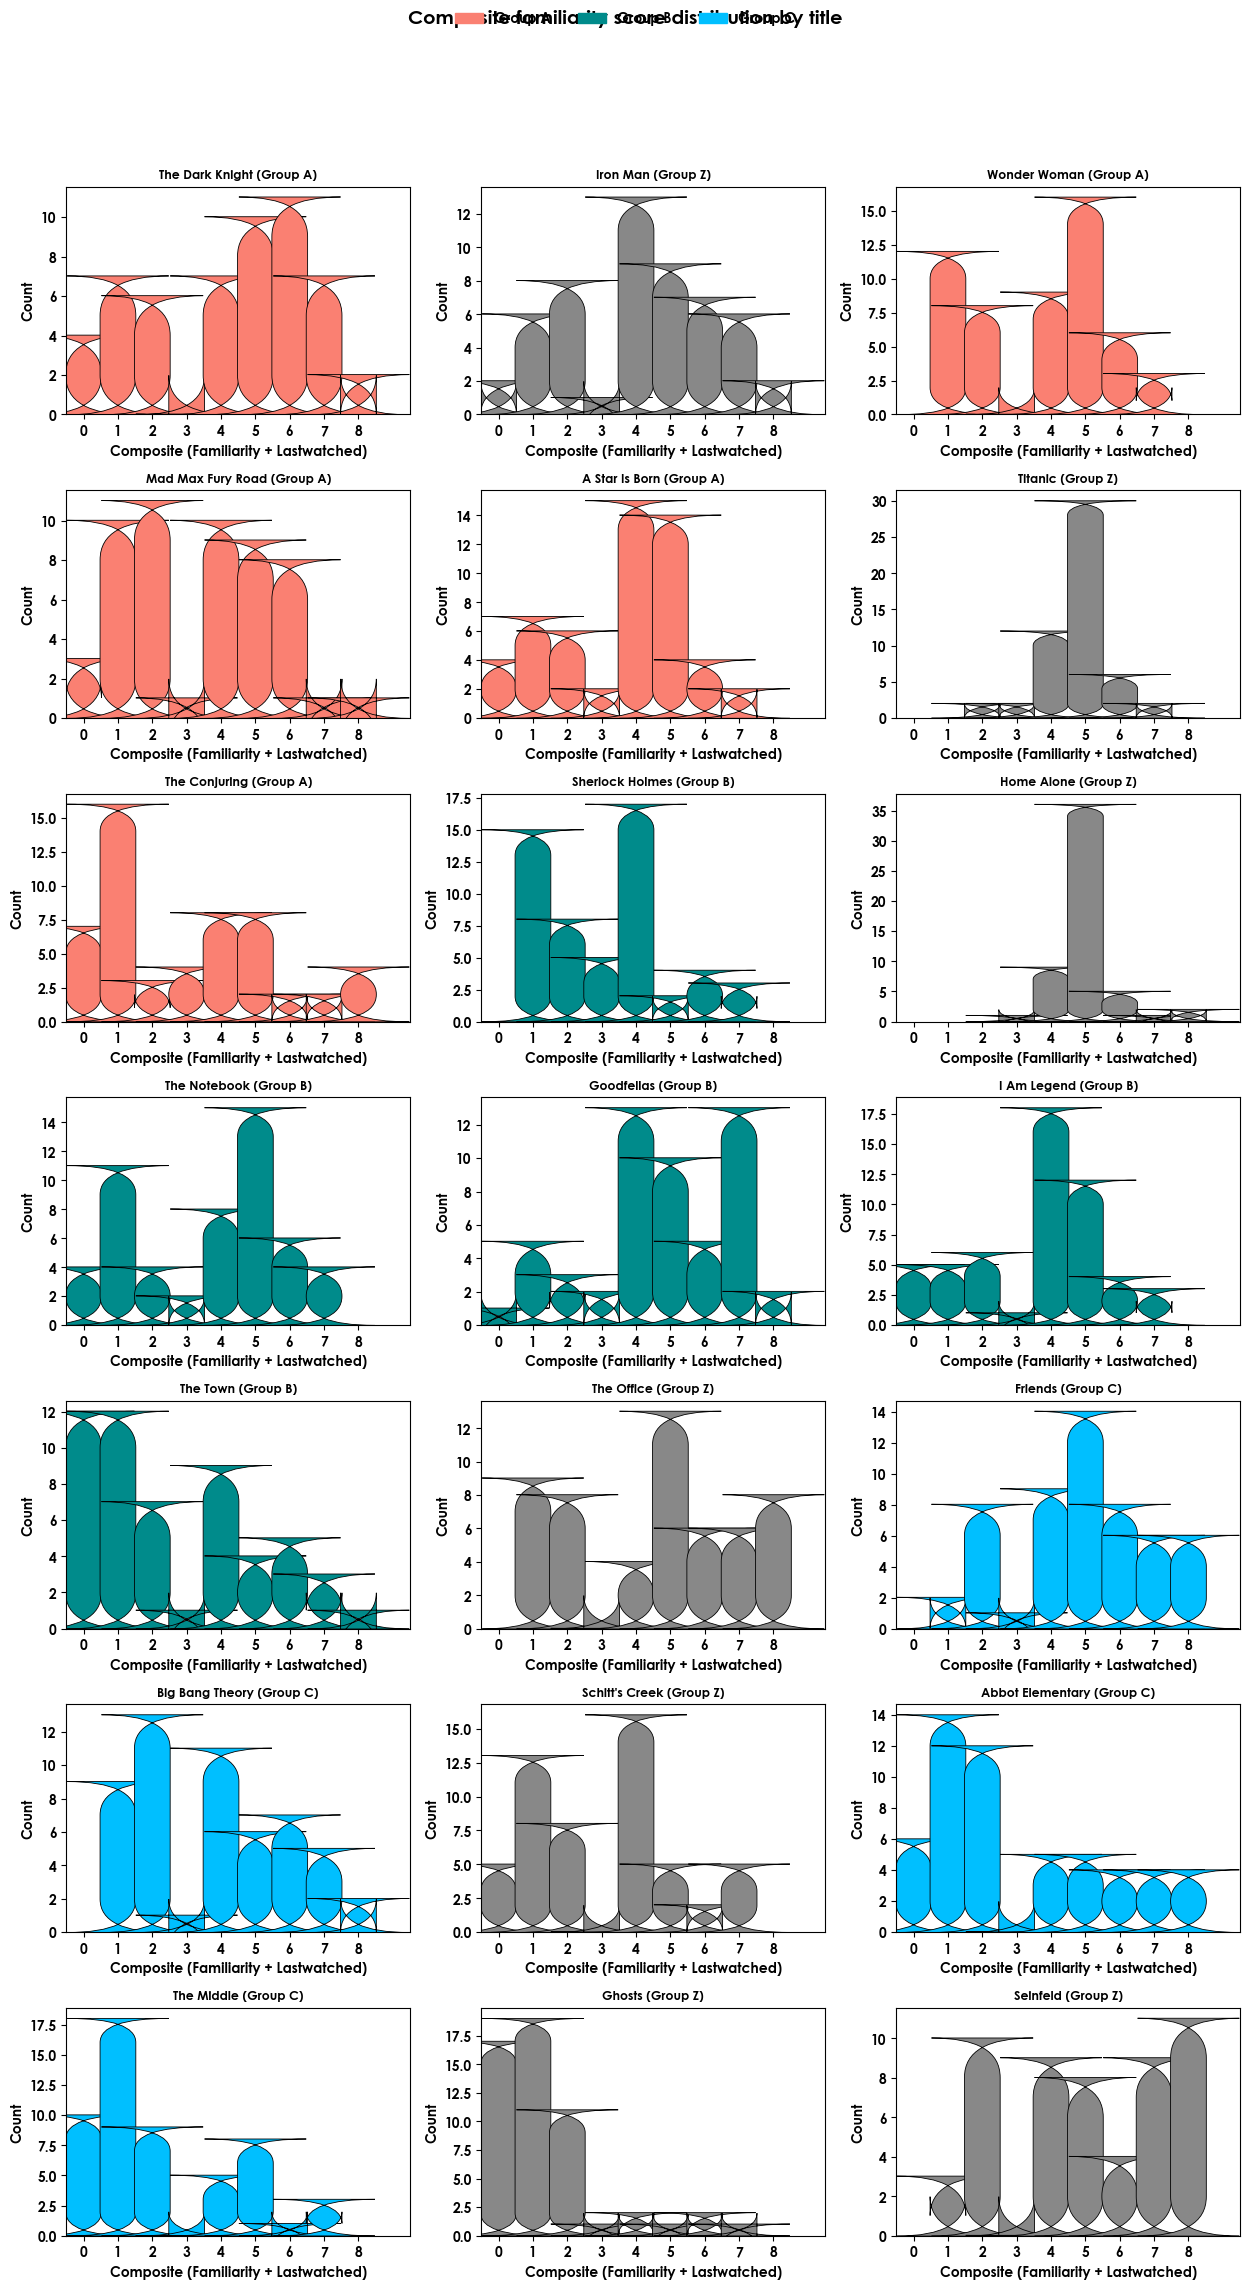

In [16]:
# --- Analysis 3: Histograms of composite distributions (colored by Group, formatted) ---
import math
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyBboxPatch

# Set global font
plt.rcParams['font.family'] = 'Century Gothic'

# Determine which titles to keep: drop titles with zero familiarity AND zero lastwatched non-null responses
kept_titles = []
for title, metrics in title_metrics.items():
    fam_col = metrics.get('Familiarity')
    lw_col  = metrics.get('Lastwatched')
    fam_non_null = df_analysis[fam_col].notna().sum() if fam_col in df_analysis else 0
    lw_non_null  = df_analysis[lw_col].notna().sum() if lw_col in df_analysis else 0
    if fam_non_null>0 or lw_non_null>0:
        kept_titles.append(title)

print(f"Titles retained for plotting (have at least one familiarity or lastwatched response): {len(kept_titles)}")
print(sorted(kept_titles))

# Build title -> group map from metadata
title_to_group = {row.Title_norm: row.Group for _, row in meta.iterrows()}
# Updated color map per request
color_map = {'A': 'salmon', 'B': 'darkcyan', 'C': 'deepskyblue'}  # darkcyan ~ deepseagreen substitute if not available

n = len(kept_titles)
cols = 3
rows = math.ceil(n/cols) if n else 0

fig, axes = plt.subplots(rows, cols, figsize=(cols*4.2, rows*3.2)) if n else (None, [])
axes_list = axes.flatten() if n else []

# Hide unused axes
for ax in axes_list[n:]:
    ax.set_visible(False)

for i, title in enumerate(kept_titles):
    ax = axes_list[i]
    comp_col = f"{title}_composite"
    if comp_col not in df_analysis:
        ax.set_visible(False)
        continue
    data = df_analysis[comp_col].dropna()
    grp = title_to_group.get(title, 'Z')
    color = color_map.get(grp, '#888888')  # gray fallback
    bins = range(int(data.min()) if len(data)>0 else 0, int(data.max())+2 if len(data)>0 else 1)
    sns.histplot(data, bins=bins, ax=ax, kde=False, discrete=True, color=color, edgecolor='black', linewidth=0.6)
    # Round the rectangle corners manually (histplot returns patches)
    for p in ax.patches:
        # Replace rectangle with rounded box
        bb = p.get_bbox()
        p.remove()
        patch = FancyBboxPatch((bb.x0, bb.y0), bb.width, bb.height,
                               boxstyle="round,pad=0.02,rounding_size=2",
                               linewidth=0.6, edgecolor='black', facecolor=color)
        ax.add_patch(patch)
    ax.set_title(f"{title} (Group {grp})", fontsize=9)
    ax.set_xlabel('Composite (Familiarity + Lastwatched)')
    ax.set_ylabel('Count')
    ax.set_xlim(-0.5, 9.5)  # Familiarity (0-4) + Lastwatched (0-4) -> 0-8
    ax.set_xticks(range(0,9))

# Add a simple legend proxy
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=c, label=f'Group {g}') for g,c in color_map.items() if any(title_to_group.get(t)==g for t in kept_titles)]
if patches:
    fig.legend(handles=patches, loc='upper center', ncol=len(patches), frameon=False)

fig.suptitle("Composite familiarity score distribution by title", fontsize=14, y=1.02)
plt.tight_layout(rect=(0,0,1,0.97))
plt.show()

Found 4 Group C Episodes columns (out of 8 total Episodes cols).


C:\Users\ashra\AppData\Local\Temp\ipykernel_23528\3537738648.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data, order=[1,2,3,4], palette=['#1f77b4'], ax=ax)
C:\Users\ashra\AppData\Local\Temp\ipykernel_23528\3537738648.py:58: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=data, order=[1,2,3,4], palette=['#1f77b4'], ax=ax)
C:\Users\ashra\AppData\Local\Temp\ipykernel_23528\3537738648.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data, order=[1,2,3,4], palette=['#1f77b4'], ax=ax)
C:\Users\ashra\AppData\Local\Temp\ipykernel_23528\3537738648.py:58: UserWarning: 
The palette li

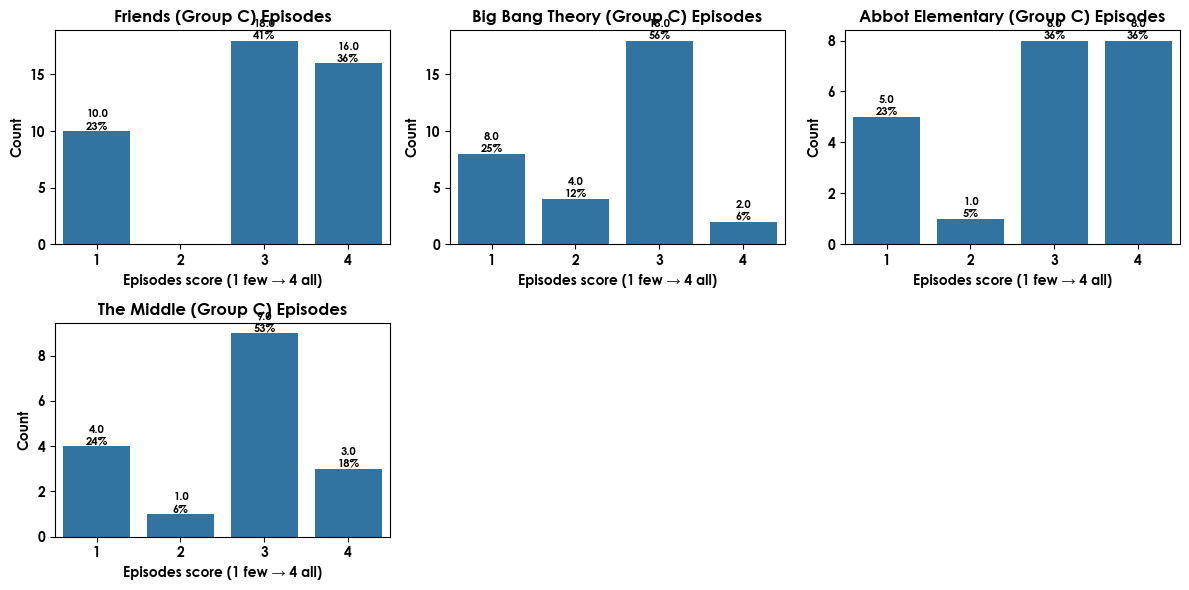

In [17]:
# --- Analysis 4: Episodes distributions for Group C titles (robust detection) ---
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd

# Patterns: group‑prefixed (A_Title_Episodes) OR original Q pattern (Q3_1_1_Title_Episodes)
pat_grouped = re.compile(r'^([A-Z])_(.+)_Episodes$')
pat_original = re.compile(r'^Q[34]_\d+_\d+_(.+)_Episodes$')

episodes_meta = []
for col in df_analysis.columns:
    if not col.endswith('_Episodes'):
        continue
    m_grp = pat_grouped.match(col)
    if m_grp:
        grp, title = m_grp.groups()
    else:
        m_orig = pat_original.match(col)
        if not m_orig:
            continue
        title = m_orig.group(1)
        # Look up group from metadata (fallback 'Z')
        grp_series = meta.loc[meta['Title_norm']==title, 'Group']
        grp = grp_series.iloc[0] if not grp_series.empty else 'Z'
    episodes_meta.append({'group': grp, 'title': title, 'col': col})

episodes_df = pd.DataFrame(episodes_meta)

if episodes_df.empty:
    print("No Episodes columns detected in current df_analysis.")
else:
    # Use bracket indexing to avoid AttributeError when empty
    group_c_eps = episodes_df[episodes_df['group']=='C']
    print(f"Found {len(group_c_eps)} Group C Episodes columns (out of {len(episodes_df)} total Episodes cols).")
    if group_c_eps.empty:
        print("No Group C Episodes data available.")
    else:
        n = len(group_c_eps)
        cols = 3
        rows = (n + cols - 1)//cols
        fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
        axes_list = axes.flatten()
        for ax in axes_list[n:]:
            ax.set_visible(False)
        for i, (_, r) in enumerate(group_c_eps.iterrows()):
            col = r.col
            ax = axes_list[i]
            ser = df_analysis[col]
            # Skip if all NaN
            if ser.notna().sum() == 0:
                ax.set_title(f"{r.title} (Group C) Episodes - no data")
                ax.axis('off')
                continue
            data = ser.dropna().astype(int)
            # Ensure only valid codes 1-4
            data = data[data.isin([1,2,3,4])]
            sns.countplot(x=data, order=[1,2,3,4], palette=['#1f77b4'], ax=ax)
            ax.set_title(f"{r.title} (Group C) Episodes")
            ax.set_xlabel('Episodes score (1 few → 4 all)')
            ax.set_ylabel('Count')
            ax.set_xticks([0,1,2,3])
            ax.set_xticklabels([1,2,3,4])
            # Annotate bars with counts & percent
            total = len(data)
            for p in ax.patches:
                height = p.get_height()
                if height>0:
                    pct = height/total*100
                    ax.annotate(f'{height}\n{pct:.0f}%', (p.get_x()+p.get_width()/2, height),
                                ha='center', va='bottom', fontsize=8)
        plt.tight_layout()
        plt.show()

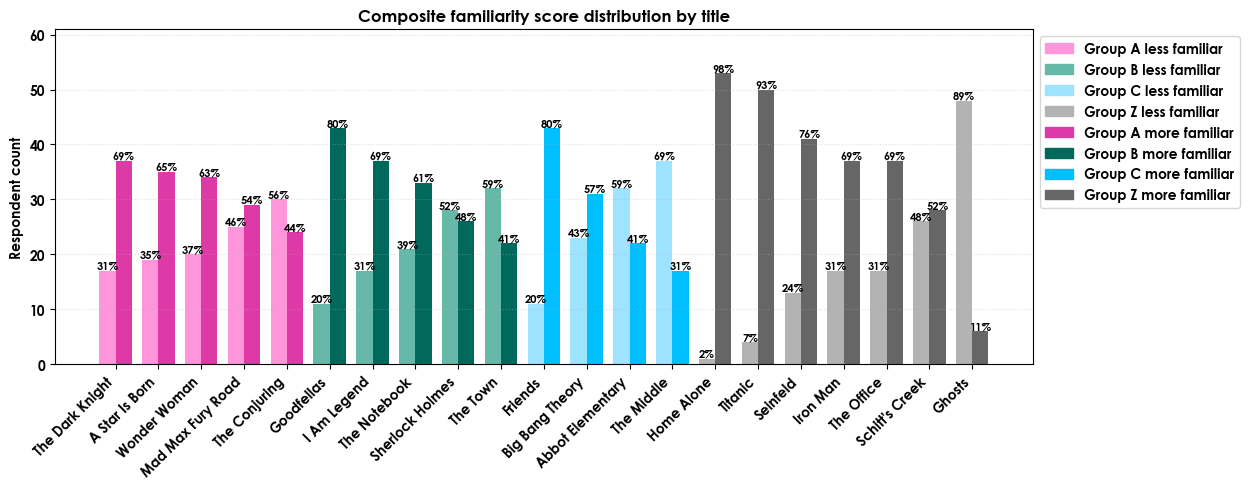

,title,group,low,high,total
0,The Dark Knight,A,17,37,54
4,A Star Is Born,A,19,35,54
2,Wonder Woman,A,20,34,54
3,Mad Max Fury Road,A,25,29,54
6,The Conjuring,A,30,24,54
10,Goodfellas,B,11,43,54
11,I Am Legend,B,17,37,54
9,The Notebook,B,21,33,54
7,Sherlock Holmes,B,28,26,54
12,The Town,B,32,22,54


In [18]:
# --- Analysis 5: Composite threshold double bar chart (<3.5 vs >=3.5) ---
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

THRESH = 3.5  # Split: <3.5 (low) vs >=3.5 (high)

# Set font to Century Gothic (fallback to default if not available)
try:
    plt.rcParams['font.family'] = 'Century Gothic'
except Exception:
    pass

# Collect composite columns (pattern: {title}_composite)
comp_cols = [c for c in df_analysis.columns if c.endswith('_composite')]
if not comp_cols:
    print("No composite columns found; run earlier analysis cells first.")
else:
    titles = [c.rsplit('_composite',1)[0] for c in comp_cols]
    title_to_group = {row.Title_norm: row.Group for _, row in meta.iterrows()}
    groups = [title_to_group.get(t, 'Z') for t in titles]

    rows = []
    for title, col, grp in zip(titles, comp_cols, groups):
        series = df_analysis[col]
        low = (series < THRESH).sum()
        high = (series >= THRESH).sum()
        total = series.notna().sum()
        rows.append({'title': title, 'group': grp, 'low': low, 'high': high, 'total': total})
    summary = pd.DataFrame(rows)
    summary = summary[summary.total > 0]
    summary = summary.sort_values(['group','high'], ascending=[True, False])

    # Updated color palette per request
    # High ("more familiar") bars use stronger tone; Low ("less familiar") bars use lighter tone
    base_colors = {  # more familiar
        'A': "#DD3AA7",   # salmon
        'B': '#00695C',   # deep sea green approximation
        'C': '#00BFFF',   # deepskyblue
        'Z': '#666666'
    }
    light_colors = {  # less familiar (lightened variants)
        'A': "#FF96DC",  # light salmon
        'B': '#66B8A9',  # light deep sea green
        'C': '#9EE3FF',  # light deepskyblue
        'Z': '#B3B3B3'
    }

    x = np.arange(len(summary))
    width = 0.38

    fig, ax = plt.subplots(figsize=(max(8, len(summary)*0.6), 5))
    bars_low = ax.bar(x - width/2, summary['low'], width, label='less familiar',
                      color=[light_colors.get(g,'#cccccc') for g in summary.group])
    bars_high = ax.bar(x + width/2, summary['high'], width, label='more familiar',
                       color=[base_colors.get(g,'#999999') for g in summary.group])

    ax.set_xticks(x)
    ax.set_xticklabels(summary['title'], rotation=45, ha='right')
    ax.set_ylabel('Respondent count')
    ax.set_title('Composite familiarity score distribution by title')

    # Annotate bars with only percent of total
    for bar, cls in zip(bars_low, summary.itertuples()):
        if bar.get_height()>0 and cls.total:
            pct = bar.get_height()/cls.total*100
            ax.annotate(f"{pct:.0f}%", (bar.get_x()+bar.get_width()/2, bar.get_height()),
                        ha='center', va='bottom', fontsize=8)
    for bar, cls in zip(bars_high, summary.itertuples()):
        if bar.get_height()>0 and cls.total:
            pct = bar.get_height()/cls.total*100
            ax.annotate(f"{pct:.0f}%", (bar.get_x()+bar.get_width()/2, bar.get_height()),
                        ha='center', va='bottom', fontsize=8)

    import matplotlib.patches as mpatches
    # Legend entries: per group & familiarity class
    legend_handles = [
        mpatches.Patch(color=light_colors[g], label=f'Group {g} less familiar') for g in sorted(summary.group.unique())
    ] + [
        mpatches.Patch(color=base_colors[g], label=f'Group {g} more familiar') for g in sorted(summary.group.unique())
    ]
    ax.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1,1))

    ax.margins(y=0.15)
    ax.grid(axis='y', linestyle=':', alpha=0.4)
    plt.tight_layout()
    plt.show()

    display(summary[['title','group','low','high','total']])

In [5]:
# Define the explicit dictionaries
familiarity_explicit = {
    'Never heard of it (not familiar).': 0,
    'Never heard of it (not familiar)': 0,
    'Heard of it, but never watched it.': 1,
    'Heard of it, but never watched it': 1,
    'Heard of it only.': 1,
    'Heard of it only': 1,
    'Seen a clip or part of it.': 2,
    'Seen a clip or part of it': 2,
    "Seen a clip or part of it (i.e., I've watched part of an episode).": 2,
    "Seen a clip or part of it (i.e., I've watched part of an episode)": 2,
    "Seen a clip or part of it (i.e., I’ve watched part of an episode).": 2,
    "Seen a clip or part of it (i.e., I’ve watched part of an episode)": 2,
    'Seen a clip or trailer': 2,
    'Seen a clip': 2,
    'Seen clips': 2,
    'Watched it in full (just once).': 3,
    'Watched it in full (just once)': 3,
    'Watched one episode': 3,
    'Watched 1 episode': 3,
    'Very familiar (e.g., watched multiple times).': 4,
    'Very familiar (e.g., watched multiple times)': 4,
    'Watched multiple episodes': 4,
    'Watched more than one episode': 4,
    'Watched more than one episode.': 4,
}

lastwatched_explicit = {
    "I don't remember.": 0,
    "I don't remember": 0,
    'I dont remember.': 0,
    'I dont remember': 0,
    'More than 6 months ago.': 0,
    'More than 6 months ago': 0,
    'Longer than 6 months ago.': 0,
    'Longer than 6 months ago': 0,
    'More than 3 months ago.': 1,
    'More than 3 months ago': 1,
    'Within the past 3 months.': 2,
    'Within the past 3 months': 2,
    'Within the past month.': 3,
    'Within the past month': 3,
    'Within the past week.': 4,
    'Within the past week': 4,
}

episodes_explicit = {
    'Only a few episodes.': 1,
    'Only a few episodes': 1,
    'All episodes from a single season.': 2,
    'All episodes from a single season': 2,
    'Most episodes from most seasons.': 3,
    'Most episodes from most seasons': 3,
    'Every episode from every season that has aired.': 4,
    'Every episode from every season that has aired': 4,
}

f_cols = [c for c in df_clean.columns if c.endswith('_Familiarity')]
l_cols = [c for c in df_clean.columns if c.endswith('_Lastwatched')]
e_cols = [c for c in df_clean.columns if c.endswith('_Episodes')]

from collections import Counter

print("Familiarity response counts:")
fam_counts = Counter()
for col in f_cols:
    for val in df_clean[col].dropna():
        if val in familiarity_explicit:
            fam_counts[val] += 1
for resp, count in sorted(fam_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{resp}: {count}")

print("\nLastwatched response counts:")
lw_counts = Counter()
for col in l_cols:
    for val in df_clean[col].dropna():
        if val in lastwatched_explicit:
            lw_counts[val] += 1
for resp, count in sorted(lw_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{resp}: {count}")

print("\nEpisodes response counts:")
ep_counts = Counter()
for col in e_cols:
    for val in df_clean[col].dropna():
        if val in episodes_explicit:
            ep_counts[val] += 1
for resp, count in sorted(ep_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{resp}: {count}")

Familiarity response counts:
Very familiar (e.g., watched multiple times).: 467
Watched it in full (just once).: 243
Heard of it, but never watched it.: 193
Never heard of it (not familiar).: 80
Seen a clip or part of it (i.e., I've watched part of an episode).: 79
Seen a clip or part of it.: 72

Lastwatched response counts:
More than 3 months ago.: 375
Within the past 3 months.: 122
Within the past month.: 95
Within the past week.: 46
I don't remember.: 46
More than 6 months ago.: 26

Episodes response counts:
Most episodes from most seasons.: 92
Every episode from every season that has aired.: 76
Only a few episodes.: 47
All episodes from a single season.: 13
